# Look into missing datasets

In [20]:
## import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc4
import tarfile
import json
import uuid as uuid
import os
from datetime import datetime, timedelta
from pathlib import Path
import s3fs

## import ECCO utils
import sys
sys.path.append('/Users/mzahn/github_others/ECCOv4-py')
import ecco_v4_py as ecco

Files Ian identified as currupt:

`KPP_hbl_day_mean.0015120000.tar.gz` <br>
`tr_adv_x_3D_day_mean.0015110000.tar.gz`<br>
`tr_adv_x_3D_day_mean.0015120000.tar.gz`

In [54]:
def load_sassie_N1_field(file_dir, fname, nk=1, skip=0):
    num_cols = 680*4 + 1080
    num_rows = 1080
    
    time_level = int(fname.split('.data')[0].split('.')[-1])
    
    tmp_compact = ecco.load_binary_array(file_dir, fname, \
                                    num_rows, num_cols, nk=nk, skip=skip, filetype='>f4')

    return tmp_compact, time_level

In [10]:
def iter_from_timestamp(timestamp_str):
    """
    takes the model timestamp and generates the model iteration number
    """
    
    ## Start time of the model is 5790000 (22.0319 years after 1992-01-01)
    ## there are 120 seconds for each iteration and 86400 seconds per day
    ## take the iteration number, convert to seconds, and calculate number of days since start of model
    
    date = np.datetime64(timestamp_str)
    
    model_start_time = np.datetime64("1992-01-01") # data.cal start time is 1992-01-01
    timestamp = date - model_start_time
    
    iter_num = int(np.array(timestamp, dtype='int')*86400/120)

    return iter_num

In [11]:
def timestamp_from_iter_num(iter_num):
    """
    takes the model iteration that was pulled from the data's filename and converts it to its equivalent datetime
    """
    ## Start time of the model is 5790000 (22.0319 years after 1992-01-01)
    ## there are 120 seconds for each iteration and 86400 seconds per day
    ## take the iteration number, convert to seconds, and calculate number of days since start of model
    
    
    ## Near the end of the simulation, Mike ran into some sort of instability so he changed the time step from 120 seconds to 60 seconds.
    if iter_num > 1e7:
        iter_num = iter_num/2
    
    num_days_since_start = iter_num*120 / 86400 ## divide iter_number by 86400 which is equal to the number of seconds in a day
    
    model_start_time = datetime(1992,1,1) # data.cal start time is 1992-01-01
    timestamp = np.array([model_start_time + timedelta(days=num_days_since_start)], dtype='datetime64[ns]')
    
    return timestamp

In [42]:
def unpack_tar_gz_files(gz_file_path, data_dir):
    tar = tarfile.open(gz_file_path, "r:gz")
    tar.extractall(data_dir) # save files to same directory
    tar.close()

### Example look into date that is missing from all datasets

In [12]:
iter_from_timestamp("2014-04-24")

5867280

In [33]:
## confirm which iter timestep we need to look at
timestamp_from_iter_num(5869440)

array(['2014-04-27T00:00:00.000000000'], dtype='datetime64[ns]')

Look into that date's gz file

In [29]:
s3 = s3fs.S3FileSystem(anon=False)

In [35]:
gz_data_dir = '/home/jpluser/sassie/gz_tmp/'
s3_bucket_dir = 's3://ecco-model-granules/SASSIE/N1/'

In [37]:
filename = 'ocean_state_3D_day_mean.0005860000.tar.gz'

In [40]:
file_url = s3_bucket_dir + 'ocean_state_3D_day_mean/' + filename

In [32]:
## bring gz file to lcoal ec2
s3.download(file_url, gz_data_dir)

[None]

In [43]:
## unpack gz file
gz_file_path = gz_data_dir + filename
data_dir = gz_data_dir + '/unpacked/'

unpack_tar_gz_files(gz_file_path, data_dir)

In [45]:
data_dir_path = Path(data_dir)
data_files = np.sort(list(data_dir_path.glob('*.data')))

In [46]:
for file in data_files:
    iter_num = int(str(file).split(".")[-2])
    timestamp = timestamp_from_iter_num(iter_num)
    print(timestamp)

['2014-04-14T00:00:00.000000000']
['2014-04-15T00:00:00.000000000']
['2014-04-16T00:00:00.000000000']
['2014-04-17T00:00:00.000000000']
['2014-04-18T00:00:00.000000000']
['2014-04-19T00:00:00.000000000']
['2014-04-20T00:00:00.000000000']
['2014-04-21T00:00:00.000000000']
['2014-04-22T00:00:00.000000000']
['2014-04-23T00:00:00.000000000']
['2014-04-24T00:00:00.000000000']
['2014-04-26T00:00:00.000000000']
['2014-04-27T00:00:00.000000000']


These dates are one day ahead because the iter number (and corresponding date) indicates the end of the averaging period and what is saved in the netCDF is the middle of the averaging period

***

### Look into variables with significant gaps

#### tr_diff_x_day_mean
Only had 101 gz files

*These fields were turned off midway through because they were zero (from Mike)*

> CURRENT NETCDF COUNTS: <br>
 'DFxE_SLT_AVG_DAILY': 0, <br>
 'DFxE_TH_AVG_DAILY': 0, <br>
 'DFyE_SLT_AVG_DAILY': 0, <br>
 'DFyE_TH_AVG_DAILY': 0, <br>

In [47]:
s3 = s3fs.S3FileSystem(anon=False)
gz_data_dir = '/home/jpluser/sassie/gz_tmp/'
s3_bucket_dir = 's3://ecco-model-granules/SASSIE/N1/'

filename = 'tr_diff_x_day_mean.0005800000.tar.gz'
file_url = s3_bucket_dir + 'tr_diff_x_day_mean/' + filename

In [48]:
## bring gz file to lcoal ec2
s3.download(file_url, gz_data_dir)

[None]

In [ ]:
## unpack gz file (NOTE: I stopped decompression middway through)
gz_file_path = gz_data_dir + filename
data_dir = gz_data_dir + '/unpacked/'

unpack_tar_gz_files(gz_file_path, data_dir)

In [50]:
data_dir_path = Path(data_dir)
filename = "tr_diff_x_day_mean.0005803200.data"

DFxE_SLT_compact, DFxE_SLT_level = load_sassie_N1_field(data_dir_path, filename, nk=90, skip=0)
DFxE_TH_compact, DFxE_TH_level = load_sassie_N1_field(data_dir_path, filename, nk=90, skip=0)
DFyE_SLT_compact, DFyE_SLT_level = load_sassie_N1_field(data_dir_path, filename, nk=90, skip=0)
DFyE_TH_SLT_compact, DFyE_TH_SLT_level = load_sassie_N1_field(data_dir_path, filename, nk=90, skip=0)

load_binary_array: loading file /home/jpluser/sassie/gz_tmp/unpacked/tr_diff_x_day_mean.0005803200.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /home/jpluser/sassie/gz_tmp/unpacked/tr_diff_x_day_mean.0005803200.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /home/jpluser/sassie/gz_tmp/unpacked/tr_diff_x_day_mean.0005803200.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /home/jpluser/sassie/gz_tmp/unpacked/tr_diff_x_day_mean.0005803200.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4


In [51]:
print(np.any(DFxE_SLT_compact != 0))
print(np.any(DFxE_TH_compact != 0))
print(np.any(DFyE_SLT_compact != 0))
print(np.any(DFyE_TH_SLT_compact != 0))

False
False
False
False


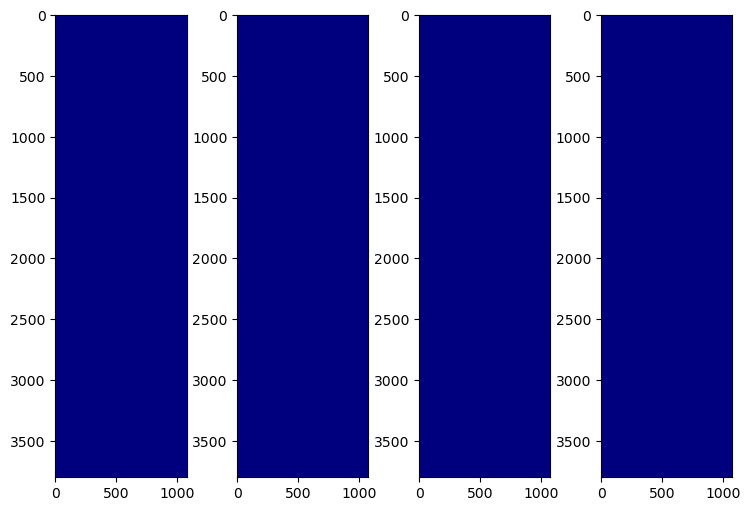

In [53]:
fig,axs = plt.subplots(1,4, figsize=[9,6])
axs[0].imshow(DFxE_SLT_compact[0,:,:], origin='lower', cmap='jet')
axs[1].imshow(DFxE_TH_compact[0,:,:], origin='lower', cmap='jet')
axs[2].imshow(DFyE_SLT_compact[0,:,:], origin='lower', cmap='jet')
axs[3].imshow(DFyE_TH_SLT_compact[0,:,:], origin='lower', cmap='jet')

for ax in axs:
    ax.invert_yaxis()

#### tr_diff_r_day_mean
gz n=199

For `tr_diff_r_day_mean` some files only have ['DFrI_SLT' 'DFrI_TH'] while others have ['DFrE_SLT' 'DFrE_TH' 'DFrI_SLT' 'DFrI_TH']

> CURRENT NETCDF COUNTS: <br>
 'DFrE_SLT_AVG_DAILY': 474, <br>
 'DFrE_TH_AVG_DAILY': 474, <br>
 'DFrI_SLT_AVG_DAILY': 240, <br>
 'DFrI_TH_AVG_DAILY': 240, <br>

#### phi_3D_day_mean
gz n=199

> CURRENT NETCDF COUNTS: <br>
 'PHIHYD_AVG_DAILY': 19, <br>
 'PHIHYDcR_AVG_DAILY': 19, <br>
 'RHOAnoma_AVG_DAILY': 5, <br>

#### KPP_mix_day_mean
gz n=199

Some KPP mix gz data files have 3 variables (diffT, diffS, and visc) and others only have 2 (diffS and visc)

> CURRENT NETCDF COUNTS: <br>
 'KPPdiffS_AVG_DAILY': 770, <br>
 'KPPdiffT_AVG_DAILY': 770, <br>
 'KPPviscA_AVG_DAILY': 448, <br>